In [254]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchmetrics
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import pandas as pd

from pathlib import Path
import mlxtend
from mlxtend.plotting import plot_confusion_matrix

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version:      {torch.__version__}\n"
      f"torchvision version:  {torchvision.__version__}\n"
      f"torchmetrics version: {torchmetrics.__version__}\n"
      f"pandas version:       {pd.__version__}\n"
      f"mlxtend version:      {mlxtend.__version__}")

PyTorch version:      2.5.1+cu124
torchvision version:  0.20.1+cu124
torchmetrics version: 1.6.0
pandas version:       2.2.3
mlxtend version:      0.23.3


In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [55]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [56]:
len(train_data), len(test_data)

(60000, 10000)

In [57]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [58]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [59]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [60]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [61]:
print(f"Image Shape: {image.shape} --> [color channels, height, width]")
print(f"Image Label: {class_names[label]}")

Image Shape: torch.Size([1, 28, 28]) --> [color channels, height, width]
Image Label: Ankle boot


Image Shape: torch.Size([1, 28, 28])


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

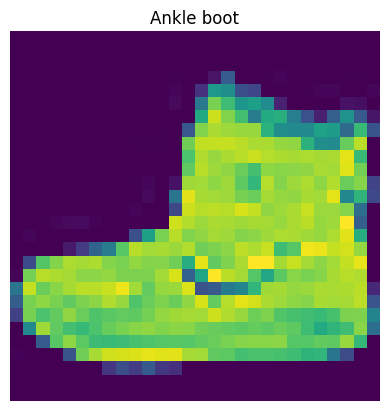

In [62]:
image, label = train_data[0]
print(f"Image Shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.axis(False)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

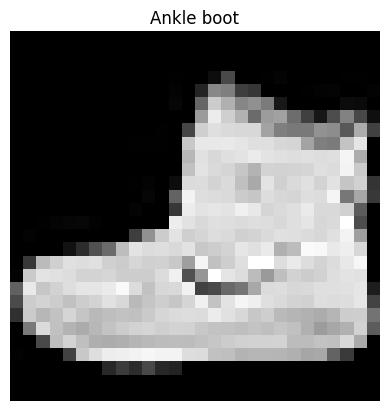

In [63]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

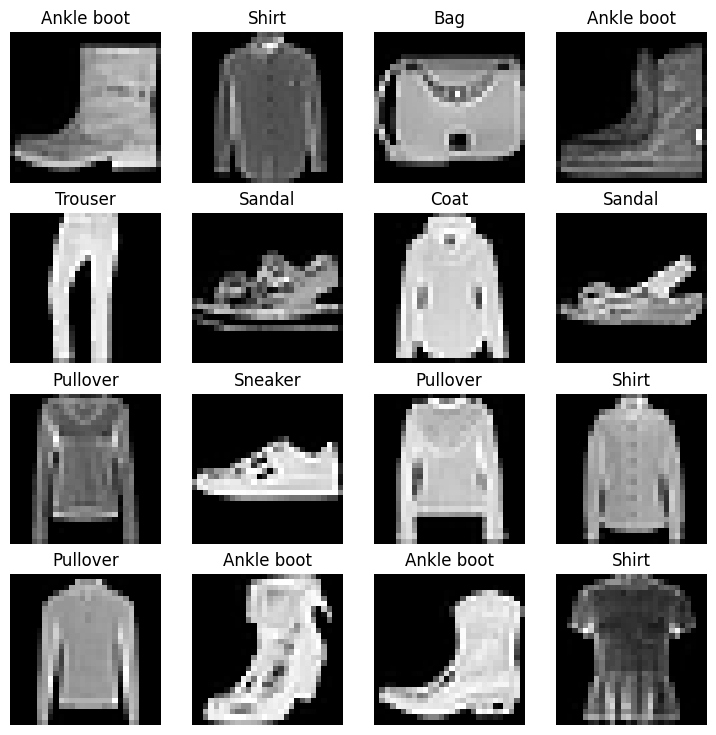

In [64]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [65]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c68281f5460>,
 <torch.utils.data.dataloader.DataLoader at 0x7c68281f5400>)

In [66]:
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7c68281f5460>, <torch.utils.data.dataloader.DataLoader object at 0x7c68281f5400>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [67]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch

(torch.Size([32, 1, 28, 28]),
 tensor([5, 1, 8, 1, 5, 2, 6, 7, 3, 5, 9, 5, 7, 5, 0, 4, 4, 4, 4, 6, 1, 8, 0, 1,
         9, 7, 8, 8, 3, 3, 7, 2]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


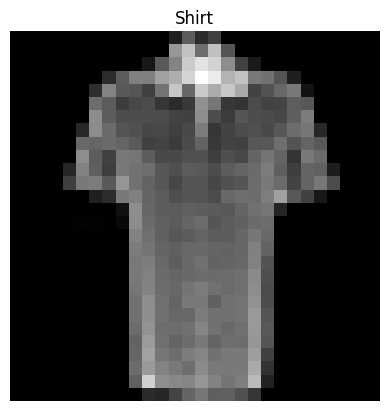

In [68]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [69]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # Perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height * width]")

# print(x)
# print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height * width]


In [70]:
class FashionModelV0(nn.Module):
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [71]:
torch.manual_seed(42)

model_0 = FashionModelV0(
    input_shape=784, # 28 * 28
    hidden_units=10,
    output_shape=len(class_names) # one for every class
).to("cpu")

if Path("models/FashionModelV0.pth").is_file():
    model_0.load_state_dict(torch.load("models/FashionModelV0.pth"))
model_0

/tmp/ipykernel_19682/3459919294.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_0.load_state_dict(torch.load("models/FashionModelV0.pth"))


FashionModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [72]:
dummy_x = torch.rand([1, 1, 28, 28]) # Linear takes a vector of 28 * 28 values. A single vector with a number per pixel
model_0(dummy_x)

tensor([[ 4.5950, -5.0415,  0.2558, -0.9267, -2.2295, -7.7880,  3.7058, -3.8369,
         12.6834, -4.4712]], grad_fn=<AddmmBackward0>)

In [73]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               accuracy_fn: torchmetrics.Accuracy,
               device: torch.device = device):
    
    """Performs a training with `model` trying to learn on `data_loader`"""

    train_loss, train_acc = 0, 0
    model_0.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples.")
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"\nTrain Loss: {train_loss:.5f} | Train Accuracy: {train_acc * 100:.2f}%")


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn: torchmetrics.Accuracy,
              device: torch.device = device):
    
    """Performs a testing loop step on `model` going over `data_loader`"""
    
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc * 100:.2f}%\n")
    return

In [74]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names))

In [75]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time"""
    total_time = end - start
    print(f"Train on {device}: {total_time:.3f} seconds")
    return total_time

In [76]:
start_time = timer()
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train on cpu: 0.000 seconds


0.00010084499990625773

In [77]:
torch.manual_seed(42)

train_time_start_on_cpu = timer()

epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n------")
    
    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=str(next(model_0.parameters()).device))

    test_step(model=model_0,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=str(next(model_0.parameters()).device))
    
    print("="*40 + "\n")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.44395 | Train Accuracy: 84.43%
Test Loss: 0.46506 | Test Accuracy: 83.65%


Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.43662 | Train Accuracy: 84.82%
Test Loss: 0.46453 | Test Accuracy: 83.89%


Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.43045 | Train Accuracy: 84.88%
Test Loss: 0.46594 | Test Accuracy: 83.93%


Train on cpu: 32.142 seconds


In [78]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn: torchmetrics.Accuracy,
               device: torch.device = device):
    """Returns a dictionary containing the results of model predicting on `data_loader`."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)
        
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc.item() * 100}

In [79]:
# str(next(model_0.parameters()).device)
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=str(next(model_0.parameters()).device))
model_0_results

100%|██████████| 313/313 [00:01<00:00, 233.83it/s]


{'model_name': 'FashionModelV0',
 'model_loss': 0.46593600511550903,
 'model_acc': 83.92571806907654}

In [81]:
class FashionModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [82]:
torch.manual_seed(42)

model_1 = FashionModelV1(
    input_shape=784, # 28 * 28
    hidden_units=10,
    output_shape=len(class_names) # one for every class
).to(device)

if Path("models/FashionModelV1.pth").is_file():
    model_1.load_state_dict(torch.load("models/FashionModelV1.pth"))
model_1

/tmp/ipykernel_19682/634070762.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load("models/FashionModelV1.pth"))


FashionModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [83]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=10).to(device)

In [84]:
train_time_start_on_gpu = timer()

epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n------")

    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)

    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)
    
    print("="*40 + "\n")

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=str(next(model_1.parameters()).device))

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.86255 | Train Accuracy: 67.63%
Test Loss: 0.91335 | Test Accuracy: 66.21%


Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.84939 | Train Accuracy: 68.13%
Test Loss: 0.86907 | Test Accuracy: 67.63%


Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.83863 | Train Accuracy: 68.43%
Test Loss: 0.86965 | Test Accuracy: 67.31%


Train on cuda:0: 26.823 seconds


In [85]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

100%|██████████| 313/313 [00:00<00:00, 383.40it/s]


{'model_name': 'FashionModelV1',
 'model_loss': 0.8696465492248535,
 'model_acc': 67.31230020523071}

In [86]:
model_0_results

{'model_name': 'FashionModelV0',
 'model_loss': 0.46593600511550903,
 'model_acc': 83.92571806907654}

In [88]:
class FashionModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        # print(f"Output shape of classifier: {x.shape}")
        return x

In [89]:
torch.manual_seed(42)
model_2 = FashionModelV2(
    input_shape=1,
    hidden_units=24,
    output_shape=len(class_names)
).to(device)

if Path("models/FashionModelV2.pth").is_file():
    model_2.load_state_dict(torch.load("models/FashionModelV2.pth"))
model_2

/tmp/ipykernel_19682/3154556504.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2.load_state_dict(torch.load("models/FashionModelV2.pth"))


FashionModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1176, out_features=10, bias=True)
  )
)

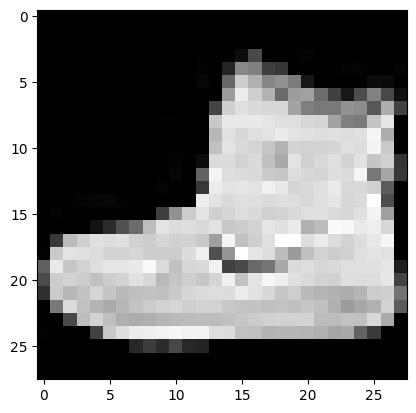

In [90]:
plt.imshow(image.squeeze(), cmap="gray")

In [91]:
torch.manual_seed(42)
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [92]:
model_2(rand_image_tensor.unsqueeze(dim=0).to(device))

tensor([[ 2.7398, -8.3725, -2.7554, -3.1122, -5.6127, 12.7615,  2.1644, -4.0943,
         10.1917, -5.0977]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [93]:
torch.manual_seed(42)

images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image Batch Shape: {images.shape}")
print(f"Single Image Shape: {test_image.shape}")
print(f"Test Image:\n {test_image}")

Image Batch Shape: torch.Size([32, 3, 64, 64])
Single Image Shape: torch.Size([3, 64, 64])
Test Image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [94]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3, 3),
                       stride=1,
                       padding=0)
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

In [95]:
print(f"Test Image shape: {test_image.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv = conv_layer(test_image)
print(f"Test Image through Conv shape: {test_image_through_conv.shape}")

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Test Image through Conv and Max Pool shape: {test_image_through_conv_and_max_pool.shape}")

Test Image shape: torch.Size([3, 64, 64])
Test Image through Conv shape: torch.Size([10, 62, 62])
Test Image through Conv and Max Pool shape: torch.Size([10, 31, 31])


In [96]:
torch.manual_seed(42)

random_tensor = torch.randn(size=(1, 2, 2))
print(f"\nRandom Tensor:\n {random_tensor}")
print(f"\nRandom Tensor Shape:\n {random_tensor.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)

max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax Pool Tensor:\n {max_pool_tensor}")
print(f"\nMax Pool Tensor Shape:\n {max_pool_tensor.shape}")


Random Tensor:
 tensor([[[0.3367, 0.1288],
         [0.2345, 0.2303]]])

Random Tensor Shape:
 torch.Size([1, 2, 2])

Max Pool Tensor:
 tensor([[[0.3367]]])

Max Pool Tensor Shape:
 torch.Size([1, 1, 1])


In [97]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [98]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start_model_2 = timer()

epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n------")

    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=str(next(model_2.parameters()).device))
    
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=str(next(model_2.parameters()).device))
    
    print("="*40 + "\n")

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=str(next(model_2.parameters()).device))

Epoch: 0
------


Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.24910 | Train Accuracy: 91.08%
Test Loss: 0.26221 | Test Accuracy: 90.76%


Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.23339 | Train Accuracy: 91.57%
Test Loss: 0.25257 | Test Accuracy: 90.92%


Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.21999 | Train Accuracy: 92.02%
Test Loss: 0.25396 | Test Accuracy: 91.12%


Train on cuda:0: 37.130 seconds


In [99]:
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=str(next(model_2.parameters()).device))
model_2_results

100%|██████████| 313/313 [00:00<00:00, 318.28it/s]


{'model_name': 'FashionModelV2',
 'model_loss': 0.253962904214859,
 'model_acc': 91.12420082092285}

In [101]:
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionModelV0,0.465936,83.925718
1,FashionModelV1,0.869647,67.312300
2,FashionModelV2,0.253963,91.124201


In [105]:
# Add each training time
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionModelV0,0.465936,83.925718,32.141633
1,FashionModelV1,0.869647,67.312300,26.822810
2,FashionModelV2,0.253963,91.124201,37.129987


Text(0, 0.5, 'Model')

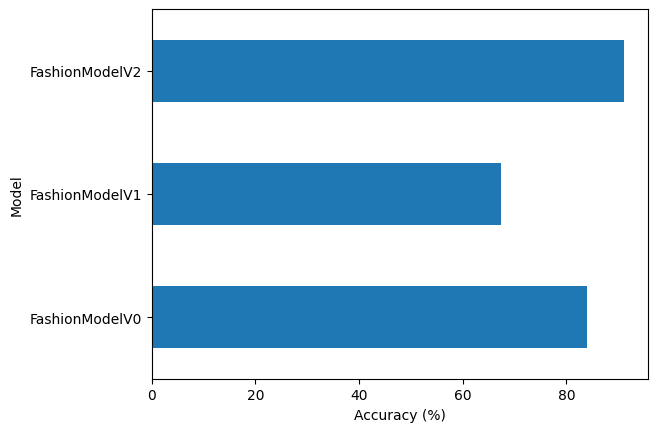

In [103]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")

In [213]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Add a batch dimension (unsqueeze)
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [214]:
img, label = test_data[0][:10]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [235]:
import random
# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sneaker')

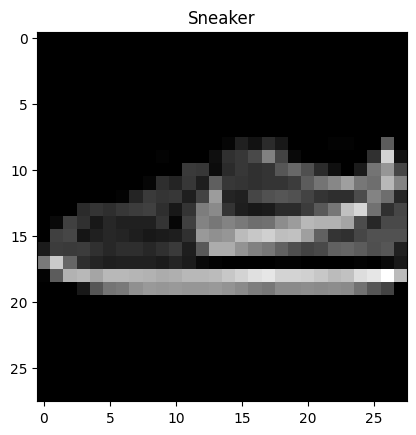

In [236]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [237]:
pred_probs = make_predictions(model=model_2,
                              data=test_samples)
pred_probs[:2]

tensor([[4.7032e-05, 2.8174e-06, 1.7532e-06, 1.2809e-04, 2.3515e-05, 7.2907e-02,
         1.1523e-04, 9.1267e-01, 1.1632e-02, 2.4695e-03],
        [9.8187e-01, 4.8858e-05, 2.9534e-05, 1.5337e-03, 1.7192e-06, 2.7001e-06,
         1.6475e-02, 1.1181e-05, 2.9963e-05, 5.4869e-07]])

In [238]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([7, 0, 0, 2, 4, 0, 2, 9, 2])

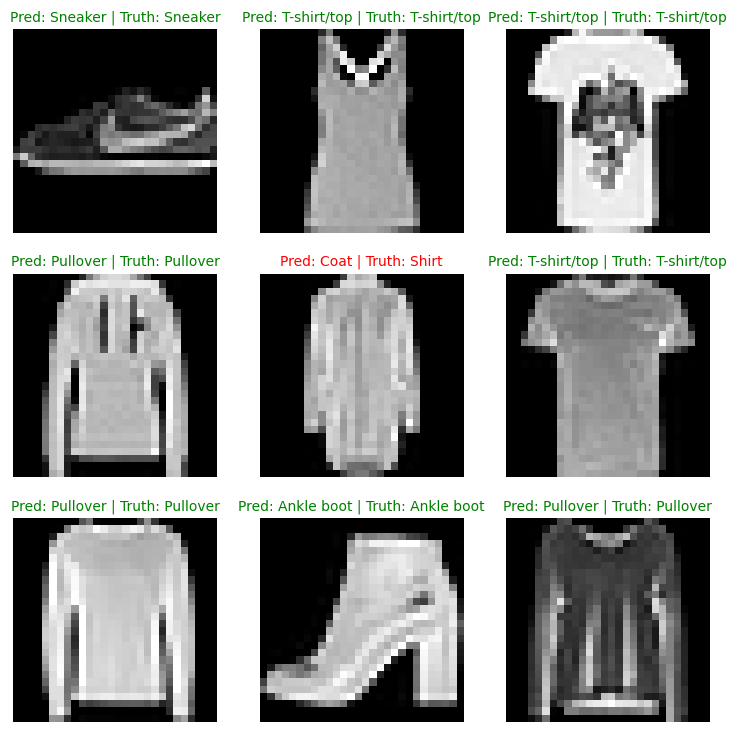

In [239]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i + 1)

    plt.imshow(sample.squeeze(), cmap="gray")

    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False)

In [247]:
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())

# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...: 100%|██████████| 313/313 [00:00<00:00, 898.49it/s]


tensor([9, 2, 1,  ..., 8, 1, 0])

In [248]:
len(y_pred_tensor)

10000

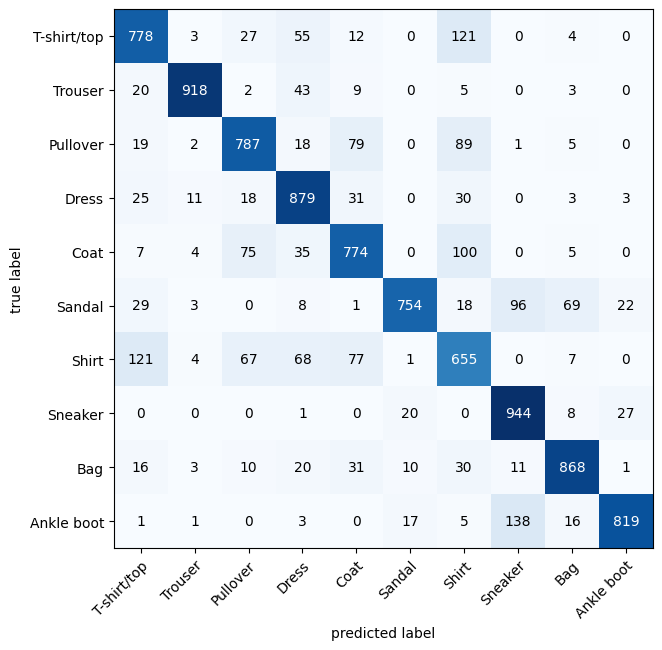

In [259]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

In [260]:
# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "FashionModelV0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/FashionModelV0.pth


In [261]:
# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "FashionModelV1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/FashionModelV1.pth


In [262]:
# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "FashionModelV2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/FashionModelV2.pth


In [273]:
loaded_model_2 = FashionModelV2(input_shape=1,
                                hidden_units=24,
                                output_shape=len(class_names))
loaded_model_2.load_state_dict(torch.load("models/FashionModelV2.pth"))
loaded_model_2.to(device)

/tmp/ipykernel_19682/2223522435.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load("models/FashionModelV2.pth"))


FashionModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1176, out_features=10, bias=True)
  )
)

In [274]:
model_2_results

{'model_name': 'FashionModelV2',
 'model_loss': 0.253962904214859,
 'model_acc': 91.12420082092285}

In [276]:
loaded_model_2_results = eval_model(model=loaded_model_2,
                                    data_loader=test_dataloader,
                                    loss_fn=nn.CrossEntropyLoss(),
                                    accuracy_fn=accuracy_fn,
                                    device=device)
loaded_model_2_results

100%|██████████| 313/313 [00:00<00:00, 547.46it/s]


{'model_name': 'FashionModelV2',
 'model_loss': 0.253962904214859,
 'model_acc': 91.12420082092285}

In [278]:
torch.isclose(torch.tensor(model_2_results["model_loss"]),
                           torch.tensor(loaded_model_2_results["model_loss"]))

tensor(True)